# Portland General Electric Demand Forecast 

To view this in Jupyter nbviewer, click [here](https://nbviewer.org/github/jackie-kinsler/energy_analysis/blob/master/energy_analysis.ipynb#gathering_data)!

This is an attempt to create a forecast of PGE's hourly demand.  
Forecasting methods in this analysis include: 
- Seasonal Naive 
- Seasonal + Trend (from temperature data) 
- Multivariate regression 

**This workbook is organized into 5 parts:**
1. [Gathering Data (EIA and Weather)](#gathering_data)
    - [Get EIA data](#eia)
    - [Get Weather data](#weather)
2. [Exploratory Data analysis](#exploratory)
    - Identify energy trends by [month](#month), [week](#week), and [hour](#hour). 
    - [Time series decomposition](#decomposition) 
    - [Explore correlation with temperature](#temperature)  
3. [Creating forecasts](#forecasts)
    - [Seasonal Naive](#naive)
    - [Multi-variate regression model](#multi_v)
    - [Seasonal forecast + trend](#season_trend)  
4. [Comparing forecasts](#compare_forecasts)
5. [Assumptions and Improvements](#a_e)

Background: PGE is a major public utility which distributes electricity to 44% of Oregon's inhabitants (including customers in Multnomah county). 

The data for this analysis comes from the U.S. Energy Information Administration (https://www.eia.gov/opendata/). Data is made available via their public API. 

Predictors will include: 
- Hour of day
- Day of week 
- Temperature 

There are certainly many more things that affect demand, including: 
- Other calendar variations (holidays, etc.)
- Price of electricity 
- Price of natural gas / other fuels 
- Economic activity 
- Industry trends (more EVs, more solar panels, more heatpumps, etc.) 
- Population changes 



In [996]:
import calendar
import datetime as dt 
from dotenv import dotenv_values 
import json
import matplotlib.pyplot as plt
import numpy as np 
import os 
import pandas as pd
import requests
from simpletsmodel import *
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from utils import *

# 1. Gathering Data (EIA and Weather) <a id='gathering_data'></a>

## EIA API Call <a id='eia'></a>
Below, the API call is made to get PGE's hourly demand and demand forecast data.

**NOTE on Time Zone**  
Data is reported in local timezones. Data is in Pacific Time. 
[source](https://www.eia.gov/electricity/gridmonitor/about)

**NOTE on Limits, and Pagination**  
"EIA's API limits its data returns to the first 5,000 rows responsive to the request."
[source](https://www.eia.gov/opendata/documentation.php)

Therefore, 12 calls will be made; one for each month. Then, the 12 calls will be concatenated into one pandas dataframe. 

To protect the API key, the key is saved in a `.env` file in the project directory. 
`dotenv` is used to load this file and source the values into the Jupyter environment. 

In [997]:
%load_ext dotenv
%dotenv -o -v

# Get the EIA_API_KEY from the environment 
EIA_API_KEY = os.environ.get("EIA_API_KEY")

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [998]:
# List of tuples consisting of (month number, number of days in month)...
months = [('01','31'),('02','28'),('03','31'),('04','30'),('05','31'),('06','30'),
          ('07','31'),('08','31'),('09','30'),('10','31'),('11','30'),('12','31')]
# empty dataframe to concatentate the data into 
dfs = []

for month in months: 
    eia_url = ('https://api.eia.gov/v2/electricity/rto/region-data/data/?' +
          f'api_key={EIA_API_KEY}&' +
          'frequency=hourly&' +
          'data[0]=value&' +
          'facets[respondent][]=PGE&' +
          f'start=2022-{month[0]}-01T00&end=2022-{month[0]}-{month[1]}T23&' +
          'sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000')
    response = requests.get(eia_url)
    eia_json = response.json()
    month_dataframe = pd.DataFrame.from_dict(eia_json['response']['data'])
    dfs.append(month_dataframe)


Concatenate the monthly data into one dataframe for 2022. 

In [999]:
pge_all_data = pd.concat(dfs)

There is a single null value, which is dropped from the table. 

In [1000]:
pge_all_data.dropna(inplace=True)

Check for any duplicate values. 

In [1001]:
pge_all_data.duplicated().any()

False

Clean the data a bit to get all of the data types into their expected format:  
- `period` needs to be updated from `object` to `datetime64`  
- `respondent`, `respondent-name`, `type`, `type-name`, and `value-units` will remain as `object`  
- `value` will remain as `float64`

Also, the data is sorted to ensure it is in ascending date order. 

In [1002]:
pge_all_data['period']= pd.to_datetime(pge_all_data['period'])

In [1003]:
# Sort ascending by time 
pge_all_data.sort_values(by='period', inplace=True)

In [1004]:
# Preview the data
pge_all_data.head(2)

,period,respondent,respondent-name,type,type-name,value,value-units
2975,2022-01-01,PGE,Portland General Electric Company,TI,Total interchange,-2202,megawatthours
2974,2022-01-01,PGE,Portland General Electric Company,NG,Net generation,891,megawatthours


## Get historic weather data for Portland, OR <a id='weather'></a>

The weather data is sourced using this api: https://open-meteo.com/  
- Time is in **Pacific Time**.  
- Temperature is the air temperature at 2 meters above ground.   
- Data is for Portland, OR 

In [1005]:
weather_url = ('https://archive-api.open-meteo.com/v1/archive?' +
               'latitude=45.52&longitude=-122.68&' +
               'start_date=2022-01-01&end_date=2022-12-31&' +
               'hourly=temperature_2m&' +
               'timezone=America%2FLos_Angeles&' +
               'temperature_unit=fahrenheit&windspeed_unit=ms&precipitation_unit=inch')

response = requests.get(weather_url)

In [1006]:
weather_data = response.json()
hourly_temp = pd.DataFrame.from_dict(weather_data['hourly'])
hourly_temp['time']= pd.to_datetime(hourly_temp['time'])
hourly_temp.rename(columns={"temperature_2m": "temp"}, inplace=True)
hourly_temp.head(2)

,time,temp
0,2022-01-01 00:00:00,22.5
1,2022-01-01 01:00:00,22.1


## Join energy and temperature data

In [1007]:
energy_and_temp = pge_all_data.merge(hourly_temp, how='inner', left_on='period', right_on='time')
energy_and_temp.drop(columns=['respondent-name', 'type'], inplace=True)
energy_and_temp.head(2)

,period,respondent,type-name,value,value-units,time,temp
0,2022-01-01,PGE,Total interchange,-2202,megawatthours,2022-01-01,22.5
1,2022-01-01,PGE,Net generation,891,megawatthours,2022-01-01,22.5


## Create New Dataframes for Demand and Forecast 

In [1008]:
demand = energy_and_temp.loc[(energy_and_temp['type-name'] == 'Demand')].copy()
demand.rename(columns={"value": "demand"}, inplace=True)
demand.set_index('period', inplace=True)
demand.sort_index()
forecast = energy_and_temp.loc[(energy_and_temp['type-name'] == 'Day-ahead demand forecast')].copy()
forecast.rename(columns={"value": "PGE_forecast"}, inplace=True)
forecast['period']= pd.to_datetime(forecast['period'])
forecast.set_index('period', inplace=True)

demand.head(2)

,respondent,type-name,demand,value-units,time,temp
period,,,,,,
2022-01-01 00:00:00,PGE,Demand,3093,megawatthours,2022-01-01 00:00:00,22.5
2022-01-01 01:00:00,PGE,Demand,3272,megawatthours,2022-01-01 01:00:00,22.1


# 2. Exploratory Analysis <a id='exploratory'></a>
Plot energy usage and temperature vs. time 
Identify energy trends by [month](#month), [week](#week), and [hour](#hour). 

## Plot of energy usage and temperature over time

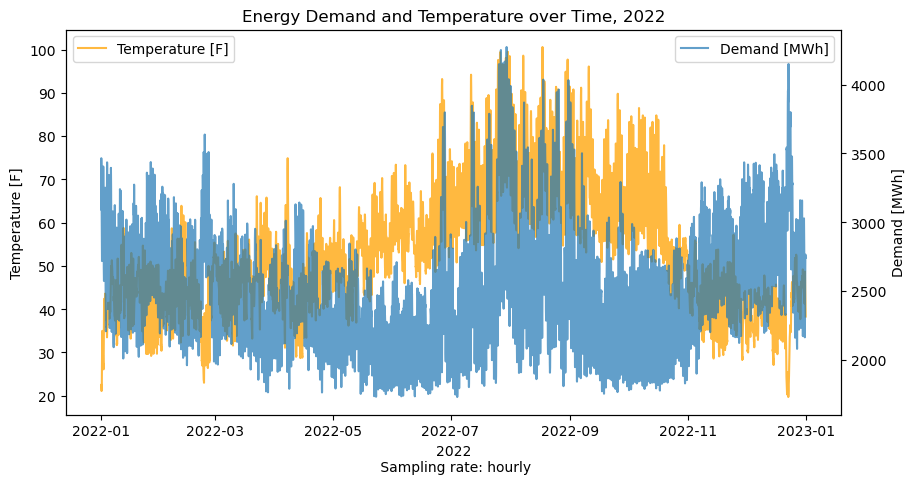

In [1009]:
fig, ax1 = plt.subplots(figsize=(10,5))
ax2 = ax1.twinx()
plt.title("Energy Demand and Temperature over Time, 2022")

ax1.plot(demand['time'], demand['temp'], label='Temperature [F]', color="#ffb940") # orange color
ax2.plot(demand['time'], demand['demand'], label='Demand [MWh]', alpha=0.7)

ax1.set_xlabel('2022\n Sampling rate: hourly')
ax1.set_ylabel('Temperature [F]')
ax2.set_ylabel('Demand [MWh]')

ax1.legend(loc=2)
ax2.legend(loc=1)
plt.show()

When temperatures dip to wintry lows or raise to summery highs, demand increases: 
- Summer months show increased demand (likely due to AC loads) 
- Winter months show increased demand (likely due to heating loads) 
- The lowest demand is during "mild temperature" months (Spring and Fall months). This is when temperatures are mild enough that neither heat nor AC are often necessary. 

## Energy Trends by [Month](#month), [Week](#week), and [Hour of Day](#hour)
Look at how the **demand per hour (DPH)** changes by month, week, and hour of day. 

### DPH by Month <a id='month'></a>

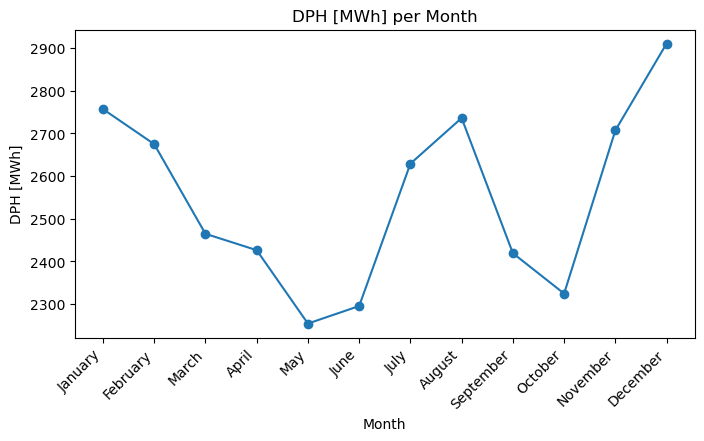

In [1010]:
energy_per_month = demand.groupby([demand.time.dt.month])['demand'].mean()

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(list(calendar.month_name[1:]), energy_per_month, marker='o')

ax.set(ylabel='DPH [MWh]', xlabel='Month')
plt.xticks(rotation=45, ha="right")
plt.title("DPH [MWh] per Month")
plt.show()

More energy usage in summer and winter (large heating and cooling demand). 

Less demand in moderate temperature months. 

### DPH by Day of Week <a id='week'></a>

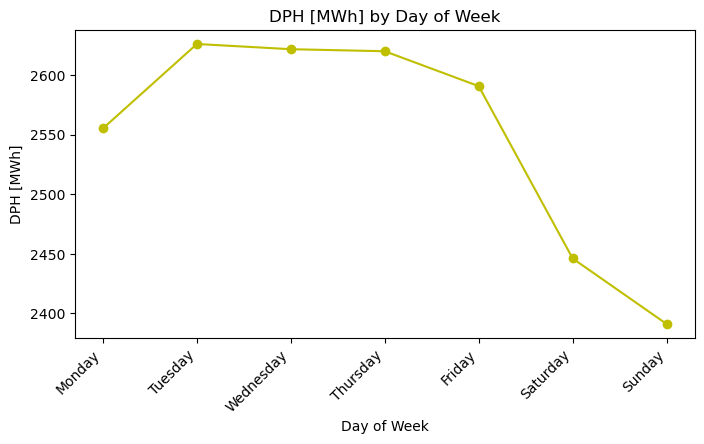

In [1011]:
# In pandas, the day of the week has Monday=0, Sunday=6
energy_per_day_of_week = demand.groupby(demand.time.dt.dayofweek)['demand'].mean()
groups = demand.groupby([pd.Grouper(key='time', freq='W'), demand.time.dt.dayofweek])['demand'].mean().to_frame().groupby(by='time')

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(list(calendar.day_name), energy_per_day_of_week, marker='o', c='y')

ax.set(ylabel='DPH [MWh]', xlabel='Day of Week')
plt.xticks(rotation=45, ha="right")
plt.title("DPH [MWh] by Day of Week")
plt.show()

Peak consumption during work days... demand drops on weekends. 

### Demand per Hour of Day <a id='hour'></a>

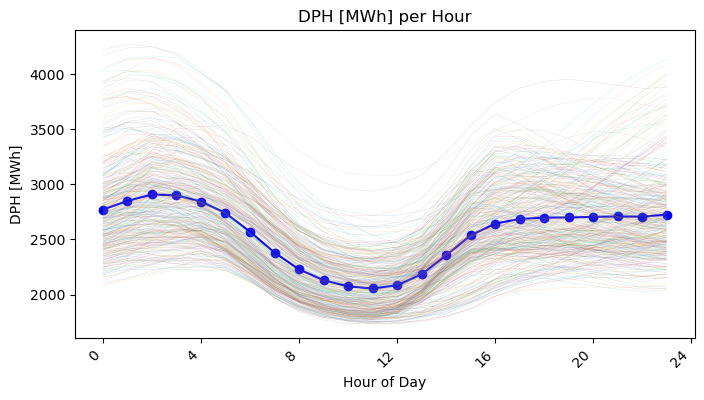

In [1012]:
# In pandas, the day of the week has Monday=0, Sunday=6
energy_per_hour = demand.groupby(demand.time.dt.hour)['demand'].mean()

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(energy_per_hour, marker='o', c='b')

for key, grp in demand.groupby([demand.time.dt.date])['demand']:
    ax.plot(grp.index.hour, grp, label=key,linewidth=0.1, alpha=0.6)

ax.set(ylabel='DPH [MWh]', xlabel='Hour of Day')
plt.xticks(np.arange(0, 25, 4).tolist(), rotation=45, ha="right")
plt.title("DPH [MWh] per Hour")
plt.show()

Daily trends show high energy consumption in early morning and evening. 

Lower energy demand during morning (8AM - 12PM)

## Time Series Decomposition for Energy Demand  <a id='decomposition'></a>
Identify seasonality within the data using an Autocorrelation plot. 

Then, identify seasonal and trend components using Seasonal Decomposition. 

### Autocorrelation 
Check for periodicity (or not!) using autocorrelation plot.  
The lag will be by the hour. 

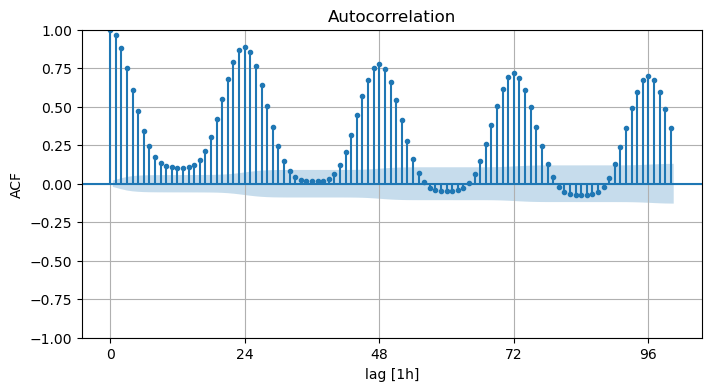

In [1013]:
fig, ax = plt.subplots(figsize=(8,4))
sm.graphics.tsa.plot_acf(demand['demand'], ax=ax, lags=100, markersize=3)
ax.set(ylim=(-1,1), xlabel='lag [1h]', ylabel='ACF')
ax.set_xticks(np.arange(0, 100, 24).tolist(), minor=False)
plt.grid()

The ACF plot shows that demand from previous day is a good indicator of demand for next day (lag of 24 hours).  
Each observations is related to observations 24-times removed (one day later). 

### Remove daily seasonality 

Taking the information from the lag chart, perform a STL decomposition (seasonal and Trend decomposition using Loess) using a 24 hour period. 

Then, plot the remaining trend on top of the original demand vs time curve. 

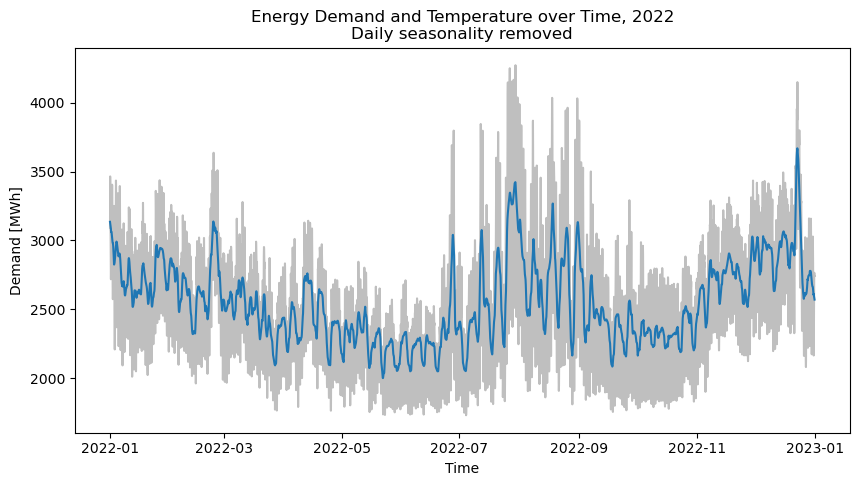

In [1014]:
day_result = seasonal_decompose(demand['demand'], period=24, model='additive', extrapolate_trend='freq')

demand['day_trend'] = day_result.trend
demand['day_seasonal'] = day_result.seasonal
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(demand['time'], demand.demand, color='.5', alpha=.5)
ax.plot(demand['time'], demand['day_trend'])
ax.set(ylabel='Demand [MWh]', xlabel='Time')
plt.title("Energy Demand and Temperature over Time, 2022\nDaily seasonality removed")
plt.show()

### Autocorrelation without daily seasonality 

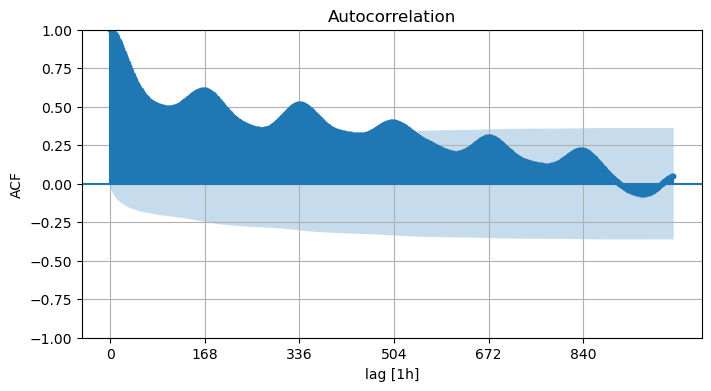

In [1015]:
fig, ax = plt.subplots(figsize=(8,4))
sm.graphics.tsa.plot_acf(demand['day_trend'], ax=ax, lags=1000, markersize=3)
ax.set(ylim=(-1,1), xlabel='lag [1h]', ylabel='ACF')
ax.set_xticks(np.arange(0, 1000, 168).tolist(), minor=False)
plt.grid()

The above ACF plot shows there is still a large seasonal component, which indicates a weekly trend (every 168 hours = 1 week). 

### Remove weekly seasonality 

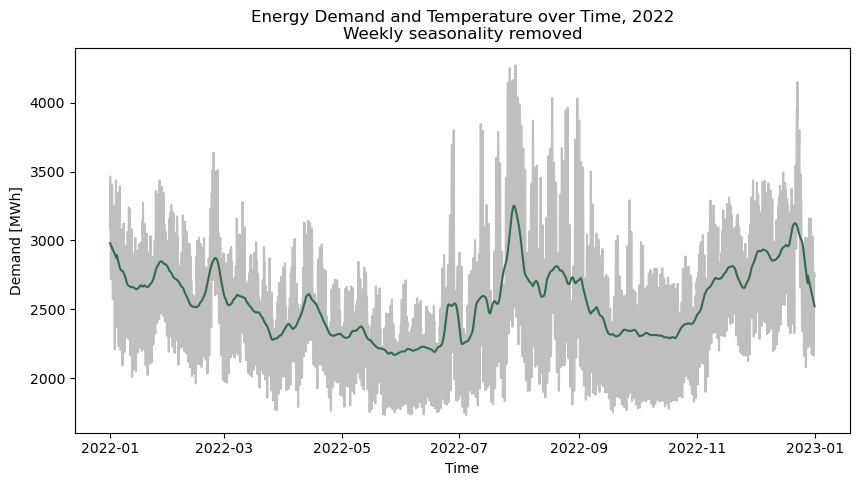

In [1016]:
week_result = seasonal_decompose(demand['day_trend'], period=168, model='additive', extrapolate_trend='freq')
# result.plot()

demand['week_trend'] = week_result.trend
demand['week_seasonal'] = week_result.seasonal
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(demand['time'], demand.demand, color='.5', alpha=.5)
ax.plot(demand['time'], demand['week_trend'], color="#36694c")
ax.set(ylabel='Demand [MWh]', xlabel='Time')
plt.title("Energy Demand and Temperature over Time, 2022\nWeekly seasonality removed")
plt.show()

## Explore Correlation with Temperature <a id='temperature'></a>
Below, we will explore how removing the seasonality of the data improves the correlation with temperature.

In the top plot (A), there is no clear relationship between temperature and demand. Especially at temperatures above 60°. 

In the bottom plot (B), there is a clear relationship between temperature and demand: 
- At very low temperatures, demand increases
- At very high temperatures, demand increases 
- There is a dip in demand at moderate temperatures 

In [1017]:
# Create a polynomial fit for the bottom graph FOR VIEWING PURPOSES ONLY 
temp_x = demand['temp'].sort_values().values.reshape(-1,1)
demand_y = week_result.trend.values.reshape(-1,1)

transformer = PolynomialFeatures(degree=2, include_bias=False)
x_ = PolynomialFeatures(degree=2, include_bias=False).fit_transform(temp_x)
model = LinearRegression().fit(x_, demand_y)

quad_coef1, quad_coef2 = model.coef_[0]
quad_intercept = model.intercept_

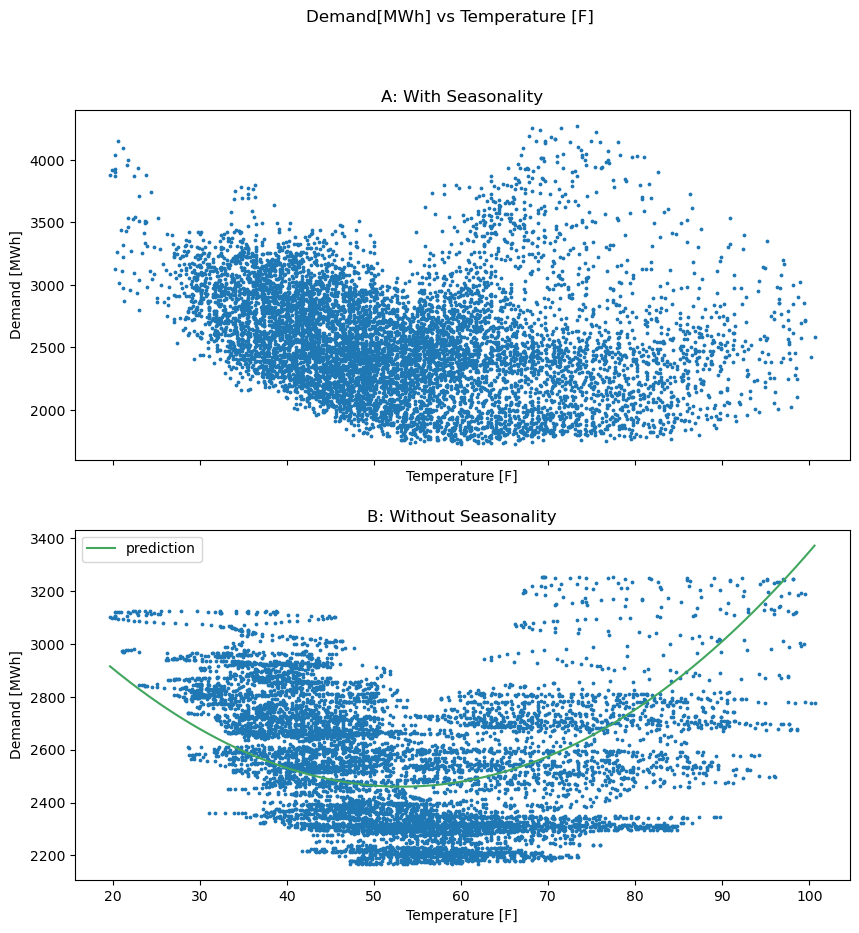

In [1018]:
# Top plot
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize=(10,10))
ax1.scatter(demand.temp, demand.demand, s=3)
ax1.set_title('A: With Seasonality')
ax1.set_xlabel("Temperature [F]")
ax1.set_ylabel("Demand [MWh]")

# Bottom plot 
ax2.scatter(demand.temp, demand.week_trend, s=3)
ax2.set_title("B: Without Seasonality")
ax2.set_xlabel("Temperature [F]")
ax2.set_ylabel("Demand [MWh]")

ax2.plot(temp_x, (quad_coef1 * temp_x + 
                  quad_coef2* temp_x**2 + 
                  quad_intercept), label = 'prediction', color = "#42a65e")
plt.legend()
plt.suptitle('Demand[MWh] vs Temperature [F]')
plt.show()

Using a quadratic fit is tempting... but a piecewise linear trend with a knot around 55 degrees F would be much better. 

Quadratic (and higher) fits often lead to misleading forecasts when they are extrapolated. 

# 3. Creating forecasts <a id='forecasts'></a>

Three forecasts will be created: 
1. **Seasonal naive forecast** (which predicts ONLY based on 1 previous period)
2. **Multi-variate regression model** (temperature, day of week, hour of day). 
3. **Seasonal forecast + trend**: The seasonal component will be naive, the trend will be influenced by temperature data. 

Then, these three forecasts will be compared to the **actual** data, as well as PGE's forecast.  

**NOTE**
"Each BA produces a day-ahead electricity demand forecast for every hour of the next day." - [Source](https://www.eia.gov/electricity/gridmonitor/about).   
Meaning that PGE only forecasts its data one day ahead of time.

### Create a Test Set 
A training and test set are created for the fit and check. 
- The training set is the first 80% of data (Jan 01 - Oct 20, midnight)
- The test set is the last 20% of data (Oct 21, 1AM - Dec 31)

In [1019]:
training.head(2)

,respondent,type-name,demand,value-units,time,temp,day_trend,day_seasonal,week_trend,week_seasonal
period,,,,,,,,,,
2022-01-01 00:00:00,PGE,Demand,3093,megawatthours,2022-01-01 00:00:00,22.5,3135.116803,221.487154,2979.790538,1.353044
2022-01-01 01:00:00,PGE,Demand,3272,megawatthours,2022-01-01 01:00:00,22.1,3130.615489,299.959132,2978.465956,-3.777044


In [1020]:
# Split the data sets into 80% training, 20% test
training = demand['2022-01-01 00:00:00' : '2022-10-21 00:00:00']
test = demand['2022-10-21 01:00:00' : '2022-12-31 23:00:00']


### Seasonal Naive Forecast <a id='naive'></a>
A seasonal naive model sets the forecast to be equal to the last observed value of an equivalent season.  
EX: Forecast power usage this upcoming Saturday at noon to whatever it was last Saturday at noon.

For this seasonal naive model, the daily seasonality will be repeated.   
(Weekly seasonality will also be shown for reference.)

Lag will be set to 24 hours, and daily trends from the last observed day will be repeated for four days. 

In [1021]:
# specificy the dataset and the lag 
end_date = '2022-11-07 23:00:00'

week_naive = TSNaiveSeasonal(training.demand, 168)
day_naive = TSNaiveSeasonal(training.demand, 24)

week_forecast = week_naive.forecast(end = end_date)
day_forecast = day_naive.forecast(end = end_date)

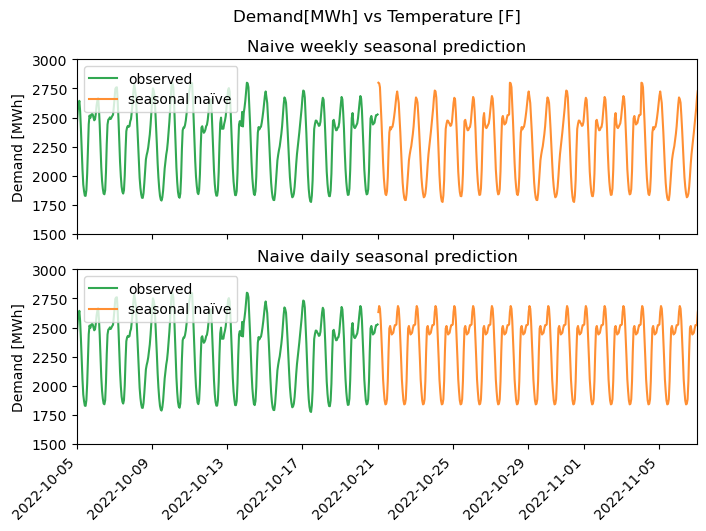

In [1022]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, sharey=True, figsize=(8,5))

# Top plot
ax1.plot(training.demand, color='#32a852', label='observed') # green 
ax1.plot(week_forecast, color='#ff8f33', label='seasonal naïve') # orange
ax1.set_ylabel("Demand [MWh]")

ax1.set_title('Naive weekly seasonal prediction')
plt.ylabel("Demand [MWh]")

# Bottom plot 
ax2.plot(training.demand, color='#32a852', label='observed') # green 
ax2.plot(day_forecast, color='#ff8f33', label='seasonal naïve') # orange

ax2.set_title('Naive daily seasonal prediction')
ax2.set_ylabel("Demand [MWh]")

plt.xticks(rotation=45, ha="right")
plt.xlim(dt.date(2022, 10, 5), dt.date(2022, 11, 7))
plt.ylim(1500,3000)

plt.suptitle('Demand[MWh] vs Temperature [F]')
ax1.legend(loc=2) ; ax2.legend(loc=2)
plt.show()

### Multi-variate regression model <a id='multi_v'></a>
A very simple multivariate regression model is made with predictors being: 
- Temperature
- Day of week 

NOTE: Hour of day should be considered, as it plays more of a role than day of the week... but perhaps a Fourier fit would be easier than separating out each hour 

In [1068]:
# Create indicator variables for day of week 
day_of_week = pd.get_dummies(mv_demand.time.dt.dayofweek, drop_first=True)

In [1069]:
day_of_week.rename(columns={1: "Tu", 2: "W", 3: "Th", 4: "F", 5: "Sa", 6: "Su"}, inplace=True)
mv_demand = pd.concat([demand, day_of_week], axis=1)
mv_demand.head()

,respondent,type-name,demand,value-units,time,temp,day_trend,day_seasonal,week_trend,week_seasonal,Tu,W,Th,F,Sa,Su
period,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,PGE,Demand,3093,megawatthours,2022-01-01 00:00:00,22.5,3135.116803,221.487154,2979.790538,1.353044,0,0,0,0,1,0
2022-01-01 01:00:00,PGE,Demand,3272,megawatthours,2022-01-01 01:00:00,22.1,3130.615489,299.959132,2978.465956,-3.777044,0,0,0,0,1,0
2022-01-01 02:00:00,PGE,Demand,3465,megawatthours,2022-01-01 02:00:00,21.8,3126.114176,358.271464,2977.141374,-12.457293,0,0,0,0,1,0
2022-01-01 03:00:00,PGE,Demand,3427,megawatthours,2022-01-01 03:00:00,21.5,3121.612862,350.808511,2975.816792,-24.811269,0,0,0,0,1,0
2022-01-01 04:00:00,PGE,Demand,3320,megawatthours,2022-01-01 04:00:00,21.2,3117.111549,294.492362,2974.492210,-38.311606,0,0,0,0,1,0


In [1070]:
# Multivariate linear regression model to fit the demand value 
fit = smf.ols('demand ~ temp + Tu + W + Th + F + Sa + Su', mv_demand).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 demand   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     142.1
Date:                Sat, 18 Feb 2023   Prob (F-statistic):          3.52e-199
Time:                        18:24:39   Log-Likelihood:                -65146.
No. Observations:                8760   AIC:                         1.303e+05
Df Residuals:                    8752   BIC:                         1.304e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2943.6484     19.696    149.452      0.000    2905.039    2982.258
temp          -7.2462      0.296    -24.440      0.000      -7.827      -6.665
Tu            71.8441     16.447      4.368      0.000      39.603     104.085
W             66.1183     16.447      4.020      0.000      33.878      98.359
Th            61.4284     16.448      3.735      0.000      29.187      93.670
F             31.0558     16.448      1.888      0.059      -1.187      63.298
Sa          -115.4328     16.372     -7.051      0.000    -147.525     -83.341
Su          -162.7095     16.447     -9.893      0.000    -194.950    -130.469
==============================================================================
Omnibus:                     1048.904   Durbin-Watson:                   0.072
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1734.990
Skew:                           0.831   Prob(JB):                         0.00
Kurtosis:                       4.411   Cond. No.                         419.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

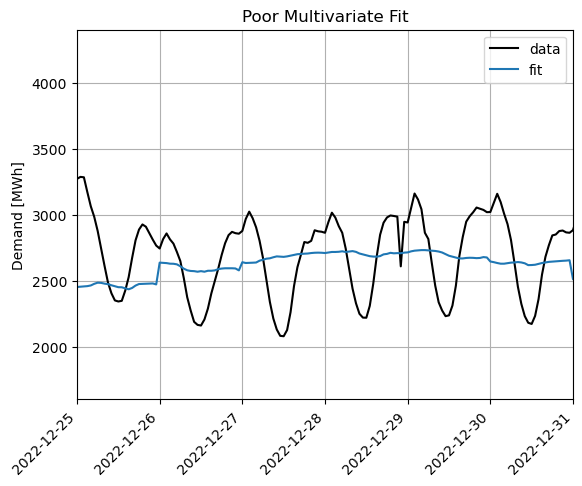

In [1071]:
fig, ax = plt.subplots()
ax.plot(mv_demand.demand, label='data', color='k')
ax.plot(mv_demand.index, fit.predict(), label='fit')
plt.xticks(rotation=45, ha="right")
plt.xlim(dt.date(2022, 12, 25), dt.date(2022, 12,31))
plt.title('Poor Multivariate Fit')
plt.ylabel("Demand [MWh]")
ax.legend()
ax.grid()

**Doesn't look very good :0**

### Seasonal forecast + trend <a id='season_trend'></a>
Here, the daily and weekly trends will be added together, as well as an estimate of the "trend", which is currently calculated using a quadratic. 

In [1026]:
training.head()

,respondent,type-name,demand,value-units,time,temp,day_trend,day_seasonal,week_trend,week_seasonal
period,,,,,,,,,,
2022-01-01 00:00:00,PGE,Demand,3093,megawatthours,2022-01-01 00:00:00,22.5,3135.116803,221.487154,2979.790538,1.353044
2022-01-01 01:00:00,PGE,Demand,3272,megawatthours,2022-01-01 01:00:00,22.1,3130.615489,299.959132,2978.465956,-3.777044
2022-01-01 02:00:00,PGE,Demand,3465,megawatthours,2022-01-01 02:00:00,21.8,3126.114176,358.271464,2977.141374,-12.457293
2022-01-01 03:00:00,PGE,Demand,3427,megawatthours,2022-01-01 03:00:00,21.5,3121.612862,350.808511,2975.816792,-24.811269
2022-01-01 04:00:00,PGE,Demand,3320,megawatthours,2022-01-01 04:00:00,21.2,3117.111549,294.492362,2974.492210,-38.311606


In [1027]:
# specificy the dataset and the lag 
end_date = '2022-11-07 23:00:00'

week_seas_naive = TSNaiveSeasonal(training.week_seasonal, 168)
day_seas_naive = TSNaiveSeasonal(training.day_seasonal, 24)

week_seas_forecast = week_seas_naive.forecast(end = end_date)
day_seas_forecast = day_seas_naive.forecast(end = end_date)

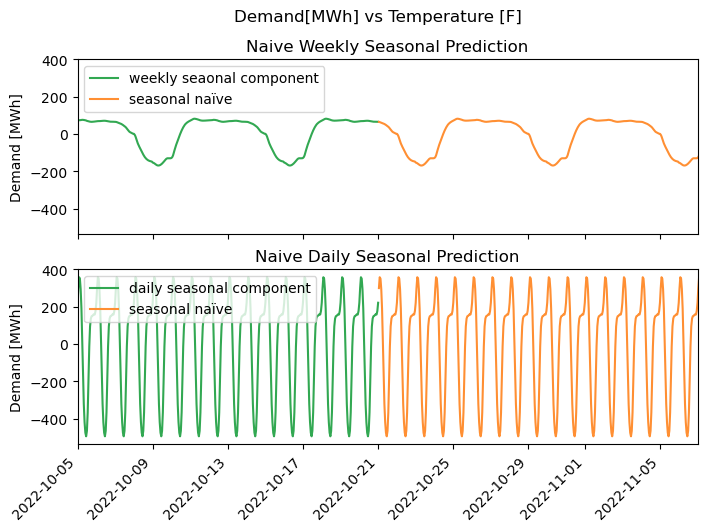

In [1028]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, sharey=True, figsize=(8,5))

# Top plot
ax1.plot(training.week_seasonal, color='#32a852', label='weekly seaonal component') # green 
ax1.plot(week_seas_forecast, color='#ff8f33', label='seasonal naïve') # orange
ax1.set_title('Naive Weekly Seasonal Prediction')
ax1.set_ylabel("Demand [MWh]")


# Bottom plot 
ax2.plot(training.day_seasonal, color='#32a852', label='daily seasonal component') # green 
ax2.plot(day_seas_forecast, color='#ff8f33', label='seasonal naïve') # orange

ax2.set_title('Naive Daily Seasonal Prediction')
ax2.set_ylabel("Demand [MWh]")

plt.xticks(rotation=45, ha="right")
plt.xlim(dt.date(2022, 10, 5), dt.date(2022, 11, 7))

plt.suptitle('Demand[MWh] vs Temperature [F]')
ax1.legend(loc=2) ; ax2.legend(loc=2)
plt.show()

In [1029]:
# Get the prediction from PGE for the test period
test_forecast = forecast['2022-10-21 01:00:00' : '2022-12-31 23:00:00']

In [1030]:
predictions = pd.concat([week_seas_forecast, 
                         day_seas_forecast, 
                         week_forecast, 
                         day_forecast, 
                         test_forecast['PGE_forecast'], 
                         test['temp'], 
                         demand['demand']], 
                        axis=1)
predictions.rename(columns={0:'week_seas_forecast', 
                            1:'day_seas_forecast', 
                            2:'week_forecast', 
                            3:'day_forecast'},
                  inplace = True)

In [1031]:
predictions['temp_trend'] = (quad_coef1 * predictions['temp'] + 
                             quad_coef2* predictions['temp']**2 + 
                             quad_intercept)

In [1032]:
predictions['sum_ST'] = (predictions.day_seas_forecast + 
                         predictions.week_seas_forecast + 
                         predictions.temp_trend)

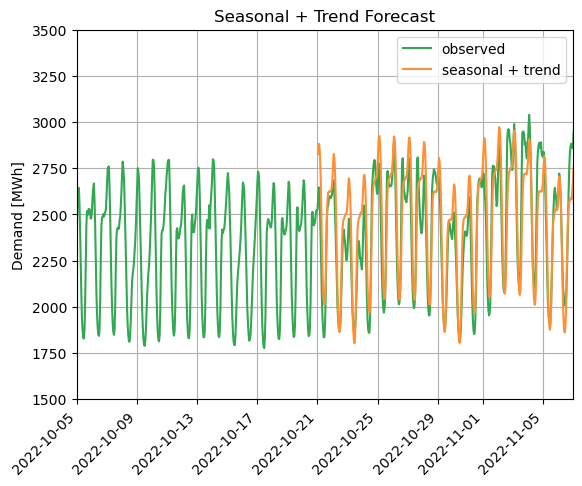

In [1033]:
fig, ax = plt.subplots()
ax.plot(demand.demand, color='#32a852', label='observed') # green 
ax.plot(predictions['sum_ST'], color='#ff8f33', label='seasonal + trend') # orange

plt.title('Seasonal + Trend Forecast')
plt.ylabel("Demand [MWh]")

plt.ylim(1500,3500)
plt.xlim(dt.date(2022, 10, 5), dt.date(2022, 11, 7))
plt.xticks(rotation=45, ha="right")

ax.legend()
ax.grid()

Forecast could probably be improved with a piecewise function for the temperature 

# 4. Comparing Forecasts <a id='compare_forecasts'></a>

**Compare PGE, Seasonal + Trend, and Seasonal Naive Forecasts** 

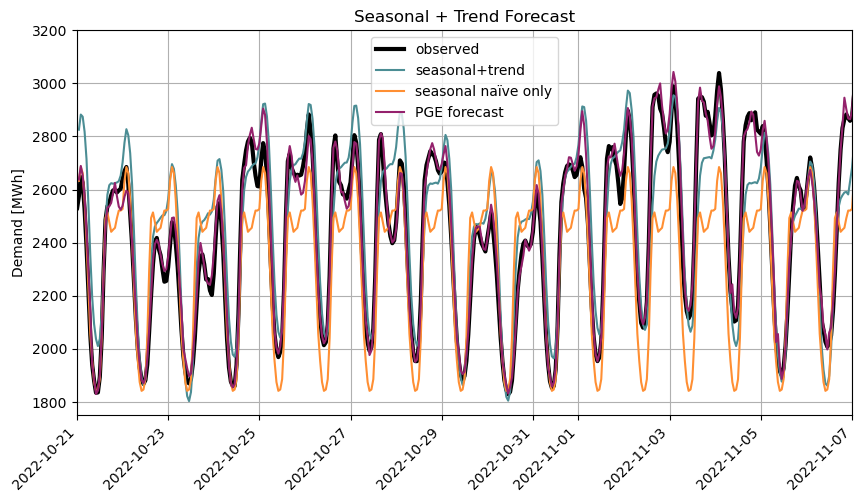

In [1036]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(demand.demand, color='#000000', linewidth=3, label='observed') # black
ax.plot(predictions['sum_ST'], color='#4b8d94', label='seasonal+trend') # blue
ax.plot(predictions['day_forecast'], color='#ff8f33', label='seasonal naïve only') # orange
ax.plot(predictions['PGE_forecast'], color ='#94216c', label='PGE forecast')

plt.title('Seasonal + Trend Forecast')
plt.ylabel("Demand [MWh]")

plt.ylim(1750,3200)
plt.xlim(dt.date(2022, 10, 21), dt.date(2022, 11, 7))
plt.xticks(rotation=45, ha="right")

ax.legend()
ax.grid()

## Check PGE's Demand Forecasting 
Let's check how good of a job PGE does forecasting their demand. 

NOTE: I believe the `Day-ahead demand forecast` values have already been appropriately shifted to be in the same row as the date they supposedly forecast for. 
I originally assumed they would need to be shifted to a day later. After manually shifting it, the R^2 value dropped from 0.98 to 0.74. 
Of course, they *may* need to be shifted, but I would be surprised if their R^2 value for forecasting was that low. 

In [1037]:
# Merge the demand and forecast tables for ease 
demand_forecast = forecast.merge(demand, how='inner', left_on='period', right_on='period')

In [1038]:
# demand array must be 2D, reshape() makes this nympy array 2D
# reshape is a numpy operator, so use .values to turn the pd series into a np array 
demand_x = demand_forecast['demand'].values.reshape(-1,1)
forecast_y = demand_forecast['PGE_forecast'].values.reshape(-1,1)
model = LinearRegression().fit(demand_x, forecast_y)
r_sq = model.score(demand_x, forecast_y)
print (f"R^2 value is {r_sq.round(3)}")

R^2 value is 0.98


Plot PGE's demand vs their forecast demand on a scatter plot with the linear fit

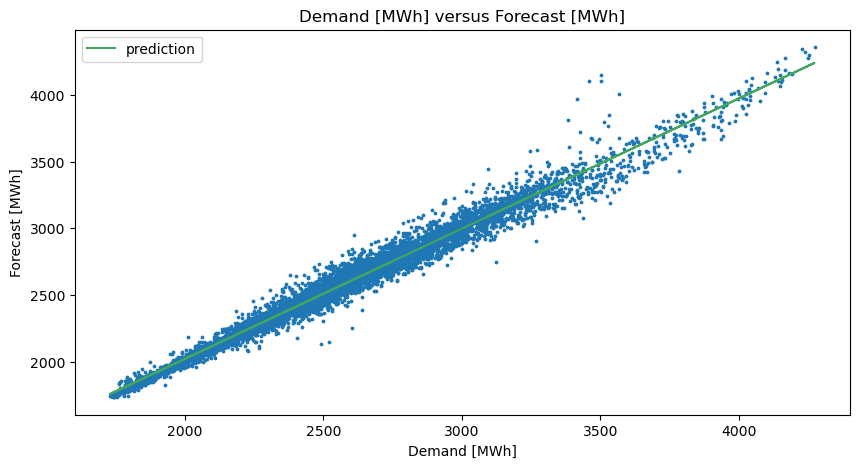

In [1039]:
plt.figure(figsize=(10,5))
plt.title('Demand [MWh] versus Forecast [MWh]')
plt.xlabel("Demand [MWh]")
plt.ylabel("Forecast [MWh]")
plt.scatter(demand_x, forecast_y, s=3)
plt.plot(demand_x, model.coef_ * demand_x + model.intercept_, label='prediction', color="#42a65e")

plt.legend()
plt.show()

# 5. Assumptions and Improvements <a id='a_e'></a>
1. Right now, only data from 2022 is used to build the model. Other years could be brought in to make the model more robust. 
2. Right now, temperature is representative of temperature in Portland, OR. Most of Oregon's population in concentrated in the Portland metro area (2.5M people of Oregon's 4.2M population). Therefore, the temperature in Portland is selected as a representative temperature. 
3. For this analysis, it is assumed that the temperature data from https://open-meteo.com/ is reliable. However, this data source should be investigated further. 

#### FURTHER INVESTIGATION IDEAS: 
1. Plot how R^2 value of demand vs PGE's forecast changes over time... assuming their modeling capabilities get better over time, R^2 should increase over time 
2. ~~Create a naive model and see how my forecast compares to it. In this case, the seasonal naive model would set the forecast to be equal to the last observed value of an equivalent season.~~ DONE!
3. Create a prediction interval for the forecast to show uncertainty of the forecast and expand on the point forecast. 
4. ~~Check if the PGE forecast is just a seasonal naive model from the day before.~~ DONE! 
5. To a piecewise fit of the temp data instead of quadratic. 